In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os

def load_sensor_data(filename):
    df = pd.read_csv(f'../Data/raw_data/{filename}', sep=',')

    # Split the data into columns
    df[['Cycle','Position','Reading']] = df['Data'].str.split(':', expand=True)
    df.drop(columns=['Data','Index'], inplace=True)

    # Clean 
    df.dropna(inplace=True)

    # Convert the data types
    df['Cycle'] = df['Cycle'].astype(int)
    df['Position'] = df['Position'].astype(int)
    df['Reading'] = df['Reading'].astype(float)

    df['Position_Gradient'] = np.gradient(df['Position'])
    df['Direction'] = df['Position_Gradient'] > 0

    # print(df.tail())
    print(f"Data loaded from {filename}")

    return df

def plot_pr_curve(df, bounds):
    df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
    plt.scatter(df_plot['Position'], df_plot['Reading'], c=df_plot['Cycle'], cmap='gist_rainbow',s=5)
    plt.title(f'Position vs Resistance, {bounds} Cycles [Color: Cycle]')
    plt.xlabel('Position')
    plt.ylabel('Resistance (ADC Value)')
    plt.colorbar()

def plot_data(df, bounds):
    df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
    df_plot2 = df_plot[(df_plot['Position'] == -400) | (df_plot['Position'] == 0)]
    plt.plot(df_plot.index, df_plot['Reading'])
    plt.scatter(df_plot2.index, df_plot2['Reading'], c=df_plot2['Position'], cmap='viridis',s=5)
    plt.title('Raw Data, 100 Cycles')
    plt.xlabel('Index')
    plt.ylabel('Resistance (ADC Value)')
    # plt.show()

print("Ready")

Ready


In [24]:
df = None
df_split = None
df_plot = None

file_name = 'data_filmed_0204_220747.csv'

# List files in the directory
files = os.listdir('../Data/raw_data')
# List files in the directory sorted by creation date
files = sorted(os.listdir('../Data/raw_data'), key=lambda x: os.path.getctime(os.path.join('../Data/raw_data', x)))

# Create a dropdown widget
file_dropdown = widgets.Dropdown(
    options=files,
    description='Select File:',
    disabled=False,
)

# Display the dropdown widget
display(file_dropdown)

df = load_sensor_data(files[-1])

# Update the file_name based on the selection
def on_file_change(change):
    global file_name, df
    file_name = change['new']

    df = load_sensor_data(file_name)

file_dropdown.observe(on_file_change, names='value')

Dropdown(description='Select File:', options=('formatted_data_0123_224049.csv', 'formatted_data_0123_224103.cs…

Data loaded from data_toast3_rerun_0219_193528.csv


Data loaded from data_toast3_rerun_0219_193528.csv


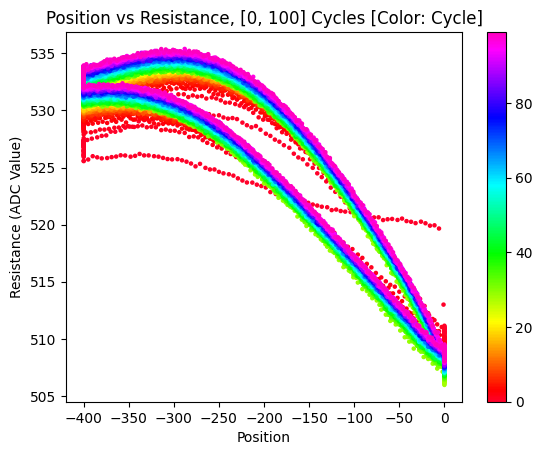

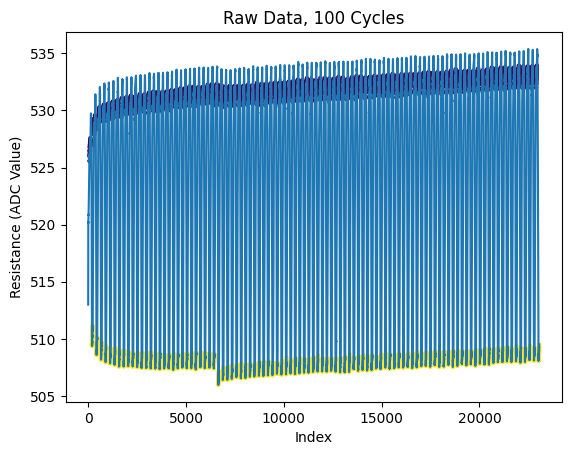

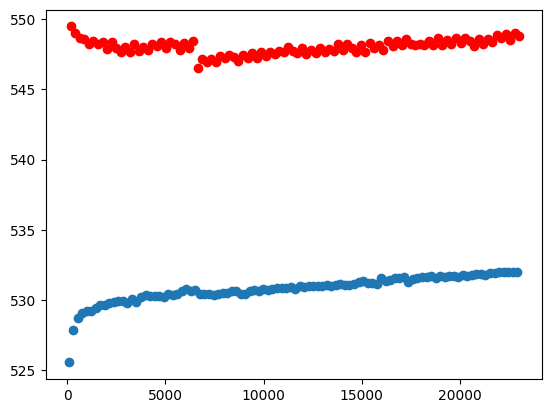

In [25]:
plot_pr_curve(df,[0,100])
plt.show()
plot_data(df,[0,100])
plt.show()
peaks = df[(df['Position'] == -400) & (df['Position'].shift(1) != -400)]
valleys = df[(df['Position'] == 0) & (df['Position'].shift(1) != 0)]
# plt.show()
plt.scatter(peaks.index,peaks['Reading'])
plt.scatter(valleys.index,valleys['Reading']+40,c='r')

[  0.84606154  95.74297509 519.21526563]


c:\Users\camca\WormMQP\.venv\Lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


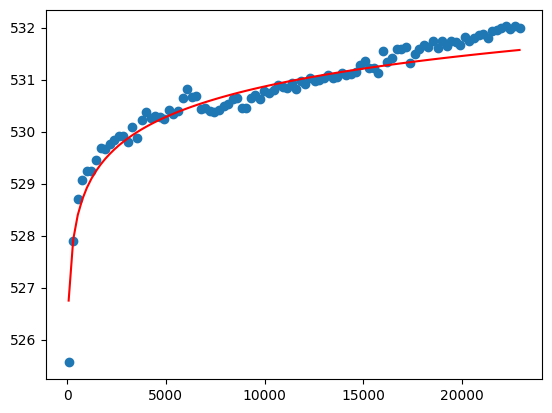

In [26]:
import scipy.optimize


def func(x, a, b, c):
    return a * np.log(b * x) + c

popt, pcov = scipy.optimize.curve_fit(func, peaks.index[0:50], peaks['Reading'][0:50])
print(popt)

plt.scatter(peaks.index,peaks['Reading'])
plt.plot(peaks.index, func(peaks.index, *popt),c='r')

Data loaded from data_toast3_0219_190827.csv
Data loaded from data_toast3_rerun_0219_193528.csv


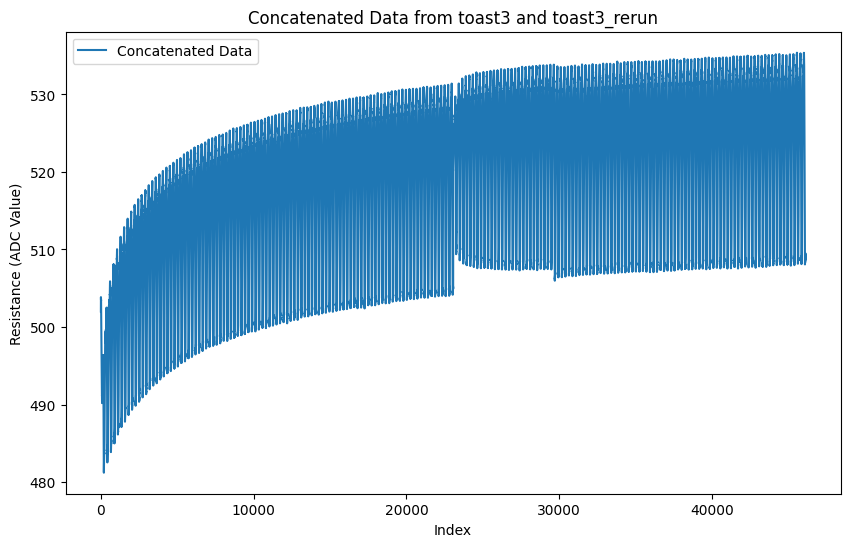

In [28]:
# Load the data for both files
df_toast3 = load_sensor_data('data_toast3_0219_190827.csv')
df_toast3_rerun = load_sensor_data('data_toast3_rerun_0219_193528.csv')

# Offset the index of the second dataframe
df_toast3_rerun.reset_index(drop=True, inplace=True)
df_toast3_rerun.index += len(df_toast3)

# Concatenate the dataframes
df_concat = pd.concat([df_toast3, df_toast3_rerun])

# Plot the concatenated data
plt.figure(figsize=(10, 6))
plt.plot(df_concat.index, df_concat['Reading'], label='Concatenated Data')
plt.title('Concatenated Data from toast3 and toast3_rerun')
plt.xlabel('Index')
plt.ylabel('Resistance (ADC Value)')
plt.legend()
plt.show()

[  6.58011074 150.65041597 427.82164852]
[   7.30207146 1553.24527953  402.43901375]
[  7.41959416 464.79464199 409.52733762]
[  6.7509149  109.90405481 429.26976285]
[  6.9152409  220.8132697  422.05736774]
[  6.89816021 471.19715222 417.03346916]
[  6.68735319 829.39605036 416.42382532]
[  5.27653635  52.59368229 454.02943125]
[  5.91343735 349.07208411 434.14982711]
[  4.91924586 289.03238132 450.72507557]


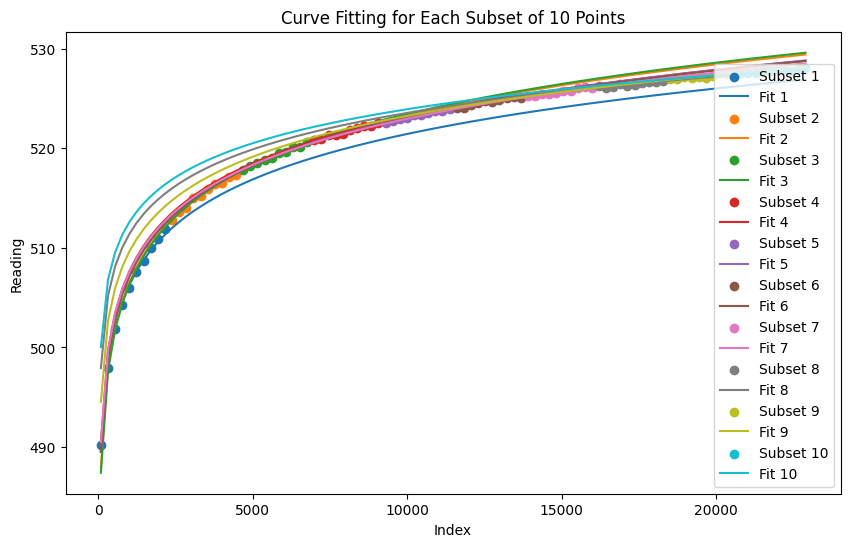

In [22]:
# Define the function to fit
def func(x, a, b, c):
    return a * np.log(b * x) + c

# Initialize a figure
plt.figure(figsize=(10, 6))

# Loop through the peaks dataframe in subsets of 10 points
for i in range(0, len(peaks), 10):
    subset = peaks.iloc[i:i+10]
    if len(subset) < 10:
        break
    x_data = subset.index
    y_data = subset['Reading']
    
    # Fit the curve
    popt, _ = scipy.optimize.curve_fit(func, x_data, y_data)
    
    # Plot the original data points
    plt.scatter(x_data, y_data, label=f'Subset {i//10 + 1}')
    
    # Plot the fitted curve
    plt.plot(peaks.index, func(peaks.index, *popt), label=f'Fit {i//10 + 1}')
    print(popt)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Reading')
plt.title('Curve Fitting for Each Subset of 10 Points')
plt.legend()
plt.show()